<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Convolutional Neural Network with Small Images</h1> 



<h3>Objective for this Notebook<h3>    
<h5> 1. Learn how to use a Convolutional Neural Network to classify handwritten digits from the MNIST database</h5>
<h5> 2. Learn hot to reshape the images to make them faster to process </h5>     



<h2>Table of Contents</h2>
<p>In this lab, we will use a Convolutional Neural Network to classify handwritten digits from the MNIST database. We will reshape the images to make them faster to process </p>

<ul>
<li><a href="#Makeup_Data">Get the Data</a></li>
<li><a href="#CNN">Build a Convolutional Neural Network Class</a></li>
<li><a href="#Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong> 14 min to train model </p>

<hr>


<h2>Preparation</h2>


In [1]:


# Import the libraries we need to use in this lab

# Using the following line code to install the torchvision library
# !mamba install -y torchvision

# !pip install torchvision==0.9.1 torch==1.8.1 
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

Defaulting to user installation because normal site-packages is not writeable


ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3
ERROR: Could not find a version that satisfies the requirement torchvision==0.9.1 (from versions: 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1)
ERROR: No matching distribution found for torchvision==0.9.1


Define the function <code>plot_channels</code> to plot out the kernel parameters of  each channel 


In [2]:
# Define the function for plotting the channels

def plot_channels(W):
    """Plots the channels of a weight tensor as a grid of images.

    Visualizes the weights of a convolutional layer as a grid of images,
    where each row represents an output channel and each column represents
    an input channel.  The weights are displayed using a color map, allowing
    for visual inspection of the learned filters.

    Args:
        W (torch.Tensor): A 4D tensor of shape (n_out, n_in, height, width)
            representing the weights of a convolutional layer.  `n_out` is the
            number of output channels, `n_in` is the number of input channels,
            and `height` and `width` are the dimensions of the kernel.

    Returns:
        None.  Displays the plot using `plt.show()`.
    """
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()

    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    # Iterate over all subplots and plot the corresponding channel weights.
    # Each subplot corresponds to a specific combination of input and output channels.
    for ax in axes.flat:

        # Increment output channel index and reset input channel index when a row is complete.
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0

        # Display the weights for the current input and output channel using a colormap.
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks and labels from the axes for cleaner visualization.
        ax.set_yticklabels([])
        ax.set_xticklabels([])

        # Increment the input channel index for the next subplot.
        in_index = in_index + 1

    plt.show()

Define the function <code>plot_parameters</code> to plot out the kernel parameters of each channel with Multiple outputs . 


In [3]:
import matplotlib.pyplot as plt

def plot_parameters(W, number_rows=1, name="", i=0):
    """Visualizes the weights of a specific kernel within a convolutional layer.

    This function extracts a specific kernel's weights from a 4D weight tensor
    and displays them as a grid of images.  Each image in the grid represents
    a different filter within the chosen kernel.  The function allows for
    customization of the grid layout and provides a title for the overall plot.

    Args:
        W (torch.Tensor): A 4D tensor of shape (n_filters, n_in, kernel_height, kernel_width)
            representing the weights of a convolutional layer. `n_filters` is the number
            of filters in the layer, `n_in` is the number of input channels, and
            `kernel_height` and `kernel_width` are the dimensions of the kernel.
        number_rows (int, optional): The number of rows to use in the grid of
            subplots. Defaults to 1.
        name (str, optional): The title to display above the plot. Defaults to an
            empty string.
        i (int, optional):  The index of the input channel to visualize. Defaults to 0.


    Returns:
        None. Displays the plot using `plt.show()`.
    """

    # Extract weights for the specified input channel
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()


    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    # Iterate over each filter and plot its weights
    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Label each subplot with the corresponding kernel number            
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Display the weights for the current filter using a colormap
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])

    # Set the title for the entire plot
    plt.suptitle(name, fontsize=10)    
    plt.show()



Define the function <code>plot_activation</code> to plot out the activations of the Convolutional layers  


In [4]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    """Visualizes the activations of a convolutional layer.

    This function displays the activations of a convolutional layer as a grid of
    images. Each image represents the activation of a single filter in the layer.
    The function allows customization of the grid layout and can display a title
    above the plot.

    Args:
        A (torch.Tensor): A 4D tensor of shape (batch_size, n_activations, height, width)
            representing the activations of a convolutional layer.  `n_activations` is the
            number of filters (or channels) in the layer output, `height` and `width` are
            the spatial dimensions of the activation maps.
        number_rows (int, optional): The number of rows in the grid of subplots.
            Defaults to 1.
        name (str, optional): The title to display above the plot. Defaults to "".
        i (int, optional): Not used in this function.  Defaults to 0.  This parameter
            is likely a remnant from a previous version and can be safely removed.

    Returns:
        None. Displays the plot using `plt.show()`.
    """

    # Extract activations from the first item in the batch and convert to NumPy
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()

    # Create a grid of subplots
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace=0.4)


    # Iterate over each activation and plot it
    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for each subplot
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Display the activation using a colormap
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')

            # Remove x and y ticks for cleaner visualization
            ax.set_xticks([])
            ax.set_yticks([])

    plt.show()




Define the function <code>show_data</code> to plot out data samples as images.


In [5]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<a id="Makeup_Data"></a>
<h2>Get the Data</h2>


We create a transform to resize the image and convert it to a tensor.


In [6]:


IMAGE_SIZE = 16


composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.


In [7]:

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:07<00:00, 1.32MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 191kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 918kB/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 758kB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Load the testing dataset by setting the parameters train  <code>False</code>.


In [8]:
# Make the validating 

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

We can see the data type is long.


In [9]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">


Print out the fourth label 


In [10]:
# The label for the fourth data element

train_dataset[3][1]

1

Plot the fourth sample 


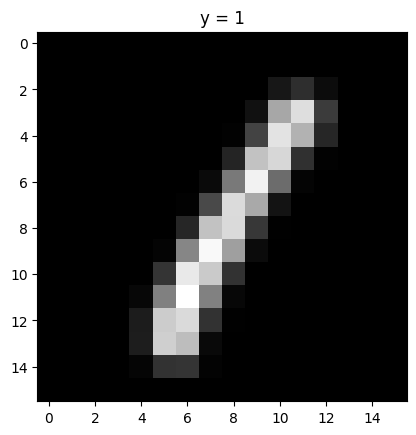

In [11]:
# The image for the fourth data element
show_data(train_dataset[3])


The fourth sample is a "1".


<!--Empty Space for separating topics-->


<a id="CNN"></a>
<h2>Build a Convolutional Neural Network Class</h2>


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.


In [12]:
class CNN(nn.Module):
    """A simple convolutional neural network (CNN).

    This CNN consists of two convolutional layers, each followed by a max-pooling
    layer, and a fully connected layer at the end.  ReLU activation is used
    after each convolutional layer.  The network is designed for single-channel
    input data (e.g., grayscale images).

    Attributes:
        cnn1 (nn.Conv2d): The first convolutional layer.
        maxpool1 (nn.MaxPool2d): The first max-pooling layer.
        cnn2 (nn.Conv2d): The second convolutional layer.
        maxpool2 (nn.MaxPool2d): The second max-pooling layer.
        fc1 (nn.Linear): The fully connected layer.
    """
    
    # Constructor
    def __init__(self, out_1=16, out_2=32):
        """Initializes the CNN with specified output channels for the convolutional layers.

        Args:
            out_1 (int, optional): The number of output channels for the first
                convolutional layer. Defaults to 16.
            out_2 (int, optional): The number of output channels for the second
                convolutional layer. Defaults to 32.
        """
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)  # Output size is 10
    
    # Prediction
    def forward(self, x):
        """Performs a forward pass through the CNN.

        Args:
            x (torch.Tensor): The input tensor.  Expected shape is
                (batch_size, 1, height, width).

        Returns:
            torch.Tensor: The output tensor after passing through all layers.
                Shape is (batch_size, 10).
        """
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each steps
    def activations(self, x):
        """Returns the activations of each layer in the CNN.

        This method is useful for debugging and visualizing the intermediate
        outputs of the network.

        Args:
            x (torch.Tensor): The input tensor. Shape is (batch_size, 1, height, width).

        Returns:
            tuple: A tuple containing the activations of each layer:
                - z1: Output of the first convolutional layer before ReLU.
                - a1: Output of the first convolutional layer after ReLU.
                - z2: Output of the second convolutional layer before ReLU.
                - a2: Output of the second convolutional layer after ReLU.
                - out1: Output of the second max-pooling layer.
                - out: Flattened output of the second max-pooling layer.
        """
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)

        # Flatten the tensor
        out = out1.view(out1.size(0), -1)
        return z1, a1, z2, a2, out1, out



<a id="Train"></a>
<h2>Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h2>


There are 16 output channels for the first layer, and 32 output channels for the second layer 


In [13]:
# Create the model object using CNN class

model = CNN(out_1=16, out_2=32)

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.


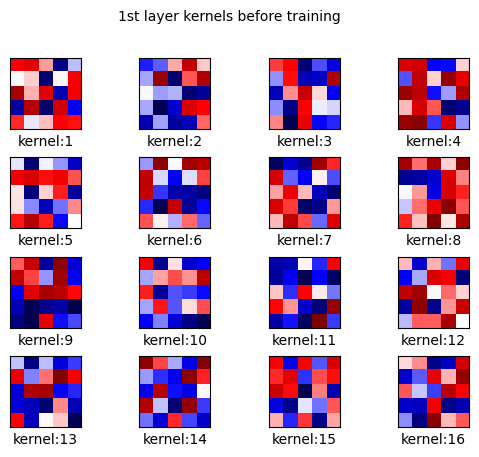

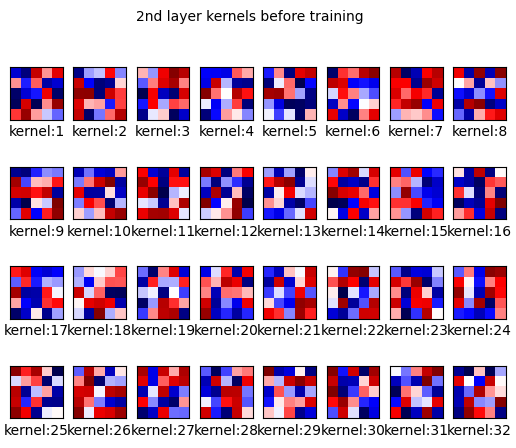

In [14]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

Define the loss function, the optimizer and the dataset loader 


In [15]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**


In [16]:
# Train the model

# Number of epochs to train for
n_epochs=3
# List to store the cost for each epoch
cost_list=[]
# List to store the accuracy for each epoch
accuracy_list=[]
# Number of samples in the validation dataset
N_test=len(validation_dataset)
# Initialize the cost
COST=0

def train_model(n_epochs):
    """Trains the neural network model for a specified number of epochs.

    Args:
        n_epochs (int): The number of epochs to train the model for.

    Returns:
        None. Updates the model's weights and biases in-place. Appends the cost and accuracy for each epoch to global lists.
    """
    for epoch in range(n_epochs):
        # Reset the cost for each epoch
        COST=0
        # Iterate through the training data loader
        for x, y in train_loader:
            # Zero the gradients of the optimizer
            optimizer.zero_grad()
            # Forward pass: compute model predictions
            z = model(x)
            # Calculate the loss
            loss = criterion(z, y)
            # Backpropagation: compute gradients of the loss w.r.t. model parameters
            loss.backward()
            # Update model parameters using the optimizer
            optimizer.step()
            # Accumulate the loss for the current epoch
            COST+=loss.data
        
        # Append the cost for the current epoch to the cost list
        cost_list.append(COST)
        # Initialize the number of correct predictions
        correct=0
        # Perform a prediction on the validation data  
        for x_test, y_test in validation_loader:  # Iterate through the validation data loader
            # Forward pass: compute model predictions on validation data
            z = model(x_test)
            # Get the predicted class labels (indices of the maximum probabilities along dimension 1)
            _, yhat = torch.max(z.data, 1)
            # Count the number of correct predictions
            correct += (yhat == y_test).sum().item()
        # Calculate the accuracy on the validation set
        accuracy = correct / N_test
        # Append the accuracy for the current epoch to the accuracy list
        accuracy_list.append(accuracy)
     
# Call the train_model function to train the model
train_model(n_epochs)


<!--Empty Space for separating topics-->


<a id="Result"></a>
<h2> Analyze Results</h2> 


Plot the loss and accuracy on the validation data:


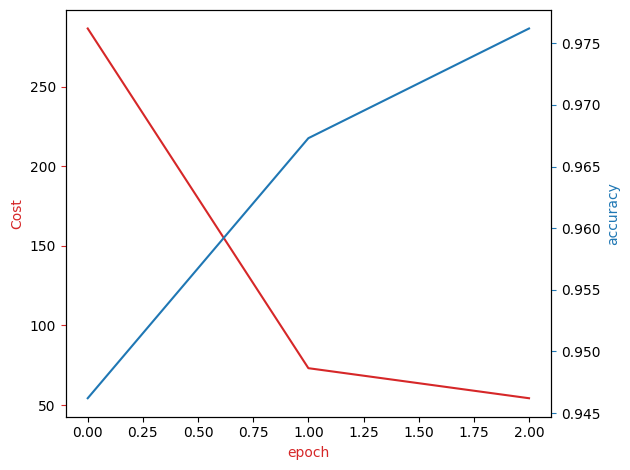

In [17]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for the Convolutional layers 


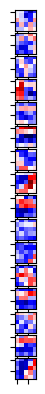

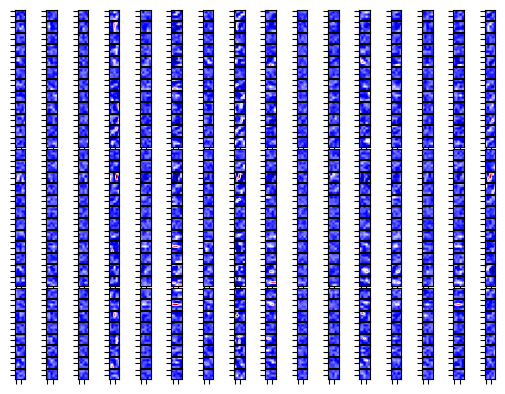

In [18]:
# Plot the channels

plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Consider the following sample 


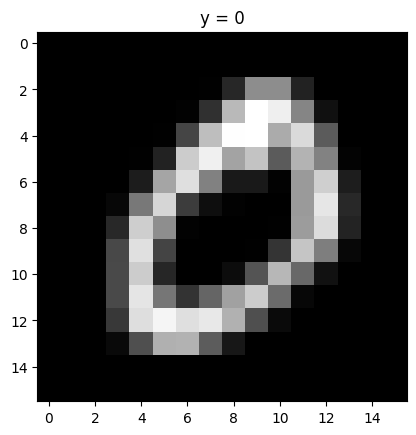

In [19]:
# Show the second image

show_data(train_dataset[1])

Determine the activations 


In [20]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Plot out the first set of activations 


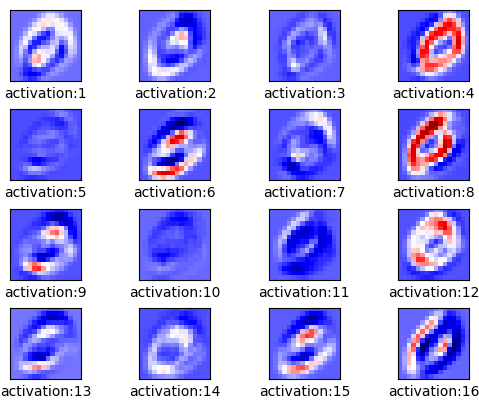

In [21]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

The image below is the result after applying the relu activation function 


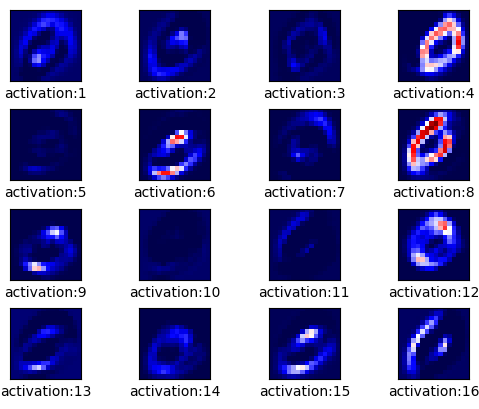

In [22]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

The image below is the result of the activation map after the second output layer.


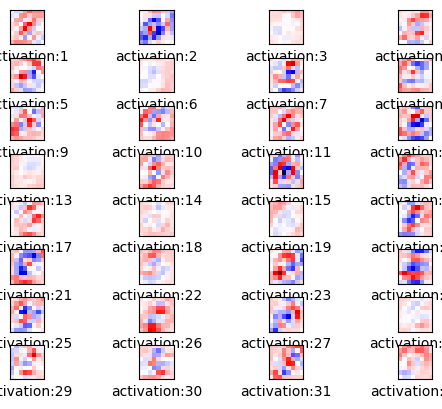

In [23]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

The image below is the result of the activation map after applying the second relu  


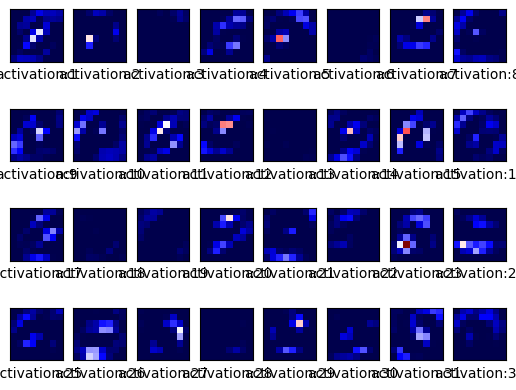

In [24]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

We can  see the result for the third sample 


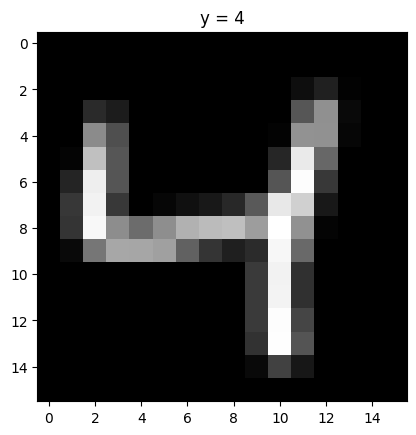

In [25]:
# Show the third image

show_data(train_dataset[2])

In [26]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

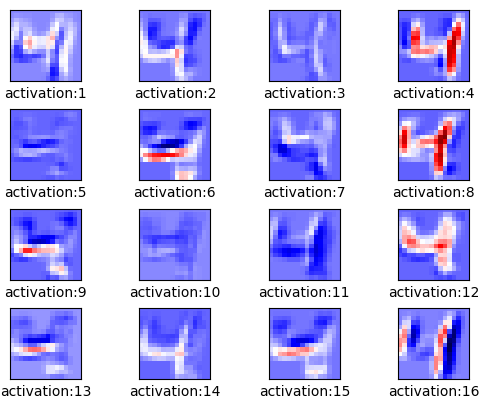

In [27]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

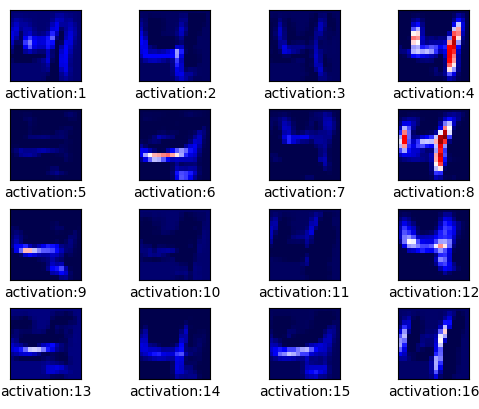

In [28]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

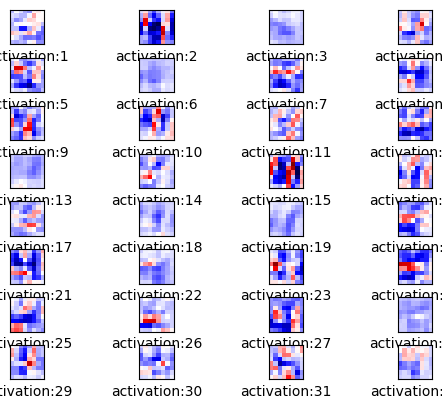

In [29]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

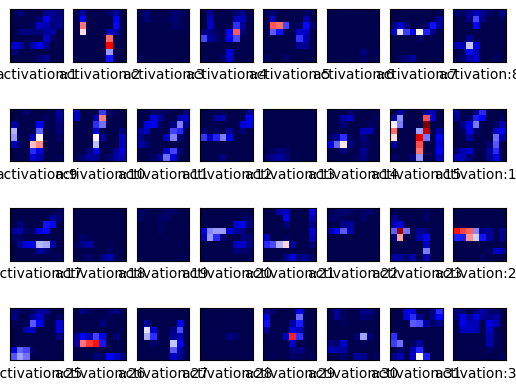

In [30]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

Plot the first five mis-classified samples:


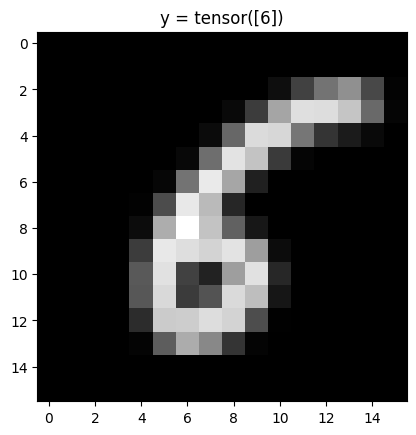

yhat:  tensor([5])


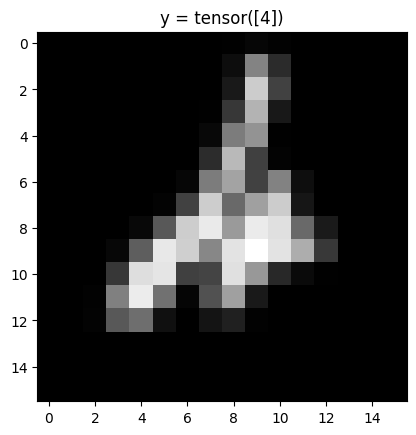

yhat:  tensor([2])


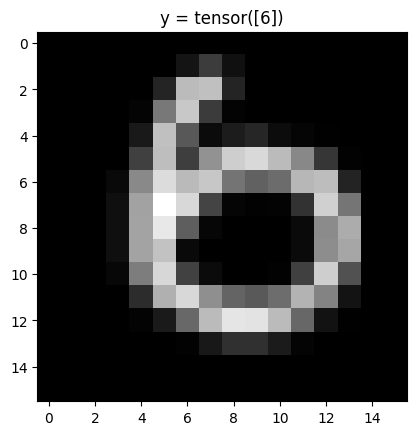

yhat:  tensor([0])


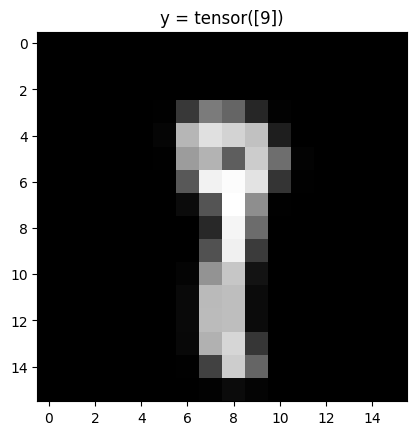

yhat:  tensor([1])


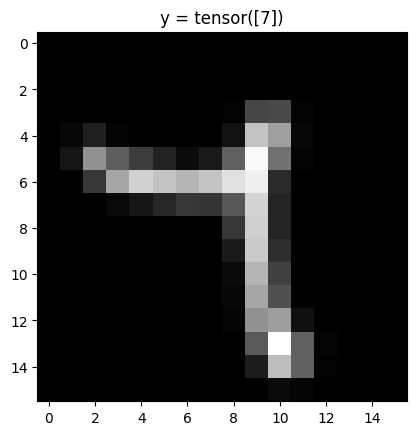

yhat:  tensor([1])


In [31]:
# Plot the mis-classified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  


<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a/">Mavis Zhou</a>


Thanks to Magnus <a href="http://www.hvass-labs.org/">Erik Hvass Pedersen</a> whose tutorials helped me understand convolutional Neural Network


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Srishti  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>
-->

## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
